# Kaggle Fake News Detection

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # https://seaborn.pydata.org/
import nltk #Natural Language Toolkit https://www.nltk.org/
nltk.download("stopwords")  #downloading stopwords
nltk.download('punkt') #https://www.kite.com/python/docs/nltk.punkt
import re # regular expression libary. https://docs.python.org/3/library/re.html


from wordcloud import WordCloud, STOPWORDS # https://www.datacamp.com/community/tutorials/wordcloud-python
#pip install wordcloud or conda install -c conda-forge wordcloud


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carolin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Carolin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Imports for the project

## Loading the data

In [2]:
real_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')
articles= pd.read_csv('news_articles.csv')

snopes = pd.read_csv('snopes_phase1_clean_2018_7_3.csv')#Might not use it

In [3]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
real_data.count()

title      21417
text       21417
subject    21417
date       21417
dtype: int64

In [5]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake_data.count()

title      23481
text       23481
subject    23481
date       23481
dtype: int64

In [7]:
articles.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [8]:
articles['label'].value_counts()

Fake    1294
Real     801
Name: label, dtype: int64

## Processing the data

In [9]:
fake_data['label']='Fake' #Creating a new column which is called label and value in it is Fake
real_data['label']='Real'#Creating a new column which is called label and value in it is Real
#This is necessary if we want to concatenate the dataframes since we need a way to identify which articles are fake and which real.

In [10]:
articles.drop(['author','site_url','main_img_url','title_without_stopwords','hasImage','text_without_stopwords','language'],inplace=True,axis=1)

#Dropping unneccessary columns so we could concatenate it easier with our other two datasets

In [11]:
articles.isna().sum()#Checking how many NaN values exist

published     0
title         0
text         46
type          1
label         1
dtype: int64

In [12]:
articles = articles.dropna()#Dropping the rows with NaN values

In [13]:
articles.isna().sum()

published    0
title        0
text         0
type         0
label        0
dtype: int64

In [14]:
from dateutil.parser import parse
def is_valid_date(s): #Function to check whether date is valid or not
    try:
        parse(s)
        return True
    except:
        return False

articles = articles[articles.published.apply(is_valid_date)]#Leaving only the rows with valid dates.
articles['published'] = pd.to_datetime(articles['published'], utc=True)#Converting arguments in published column to datetime
articles['date']=articles['published'].dt.strftime("%d %B, %Y")#Creating a new column called date 
articles.drop('published',inplace=True,axis=1)

In [15]:
articles.rename(columns={'type': 'subject'}, inplace=True)#Changing the column name type to subject

In [16]:
columns = list(articles.columns)
columns[3],columns[4]=columns[4],columns[3] #Swapping the places of columns date and label
articles =articles[columns]

In [17]:
articles.head()

,title,text,subject,date,label
0,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,bias,"26 October, 2016",Real
1,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,bias,"29 October, 2016",Real
2,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,bias,"30 October, 2016",Real
3,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,bias,"01 November, 2016",Real
4,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,bias,"01 November, 2016",Real


#### Putting the dataframes together to make one unfied dataframe

In [18]:
news = pd.concat([real_data,fake_data,articles],ignore_index=True, sort=False) #Putting the dataframes all together into our new dataframe called news

In [19]:
news.isna().sum()#Checking if there are any NaN values

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [20]:
news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",Real
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",Real


In [21]:
news['label'].value_counts()

Fake    24772
Real    22174
Name: label, dtype: int64

Now we have put the data together from the first and second Kaggle dataset.

### Text to lower case

In [22]:
news.title = news.title.str.lower()
news.text = news.text.str.lower()

### Removing stopwords and punctuation

In [23]:
title_copy =news.title.copy()
text_copy= news.text.copy()

In [24]:
stopwords = nltk.corpus.stopwords.words("english")
def remove_stopwords(text):
    text_to_token = nltk.word_tokenize(text)
    remove_stopwords = [word for word in text_to_token if not word in stopwords]
    join_text = ' '.join(remove_stopwords)
    return join_text

In [25]:
news_copy = news.copy()
news['title_cleaned']=news_copy.title.apply(lambda x : remove_stopwords(x))
#news['text_cleaned']=news_copy.text.apply(lambda x : remove_stopwords(x))

In [26]:
import string
def remove_punctuation(text):
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    join_text = ' '.join(stripped)
    return join_text

In [27]:
news_copy = news.copy()
news['title_cleaned']=news_copy.title_cleaned.apply(lambda x : remove_punctuation(x))
#news['text_cleaned']=news_copy.text_cleaned.apply(lambda x : remove_punctuation(x))

In [39]:
print(news.loc[news['label'] == 'Fake'].title_cleaned)

21417    donald trump sends embarrassing new year ’ eve...
21418    drunk bragging trump staffer started russian c...
21419    sheriff david clarke becomes internet joke thr...
21420    trump obsessed even obama ’ name coded website...
21421    pope francis called donald trump christmas speech
                               ...                        
46884                      report voter fraud crash course
46885      national attention ayotte hassan nh senate race
46886                                     honest elections
46887                                    wars bankers wars
46888        snow reports around northland duluth saturday
Name: title_cleaned, Length: 24772, dtype: object


### Stem words and lemmatize verbs

In [29]:
#from nltk.stem import PorterStemmer
#porter = PorterStemmer()
#def stem_words(text):
#    token_words=nltk.word_tokenize(text)
#    stem_sentence=[]
#    for word in token_words:
#        stem_sentence.append(porter.stem(word))
#        stem_sentence.append(" ")
#    return "".join(stem_sentence)


#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemma_words(text):
    token_words=nltk.word_tokenize(text)
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(word.format(word,wordnet_lemmatizer.lemmatize(word, pos="v")))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

### Most used words in fake news articles' titles

In [44]:
fake_rows = news.loc[news['label'] == 'Fake']
fake_copy = fake_rows.copy()

fake_rows['title_lemma']=fake_copy.title_cleaned.apply(lambda x : lemma_words(x))
fake_title_freq = pd.Series(' '.join(fake_rows.title_lemma).split()).value_counts()
fake_title_freq = fake_title_freq.drop(labels=['’', '”','“','‘','–'])
fake_title_dict = fake_title_freq.to_dict()

<ipython-input-44-86a8eacad0d6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_rows['title_lemma']=fake_copy.title_cleaned.apply(lambda x : lemma_words(x))


KeyError: "[','] not found in axis"

### Most used words in real news articles' titles

In [57]:
real_rows = news.loc[news['label'] == 'Real']
real_copy = real_rows.copy()

real_rows['title_lemma_real']=real_copy.title_cleaned.apply(lambda x : lemma_words(x))
real_title_freq = pd.Series(' '.join(real_rows.title_lemma_real).split()).value_counts().drop
real_title_dict = real_title_freq.to_dict()
real_title_dict

<ipython-input-57-2da6ef780fbc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_rows['title_lemma_real']=real_copy.title_cleaned.apply(lambda x : lemma_words(x))


{'trump': 5565,
 's': 4166,
 'us': 4066,
 'says': 2992,
 'house': 1446,
 'north': 929,
 'russia': 922,
 'new': 903,
 'korea': 883,
 'white': 821,
 'china': 767,
 'senate': 766,
 'court': 731,
 'clinton': 711,
 'bill': 691,
 'obama': 667,
 'state': 655,
 'republican': 637,
 'tax': 612,
 'eu': 568,
 'may': 562,
 'deal': 552,
 'vote': 550,
 'election': 539,
 'un': 530,
 'talks': 527,
 'iran': 525,
 'pm': 521,
 'president': 507,
 'syria': 458,
 'minister': 454,
 'south': 443,
 'calls': 435,
 'police': 423,
 'factbox': 419,
 'government': 413,
 'brexit': 409,
 'leader': 402,
 'chief': 401,
 'probe': 380,
 'turkey': 372,
 'congress': 370,
 'plan': 358,
 'uk': 356,
 'party': 352,
 'republicans': 348,
 'sanctions': 347,
 'russian': 346,
 'official': 342,
 'security': 327,
 'military': 321,
 'top': 318,
 'nuclear': 314,
 'campaign': 313,
 'ban': 307,
 'democrats': 292,
 'saudi': 288,
 'governor': 286,
 'myanmar': 286,
 'urges': 285,
 'lawmakers': 282,
 'foreign': 279,
 'senator': 278,
 'law': 2

### Wordcloud

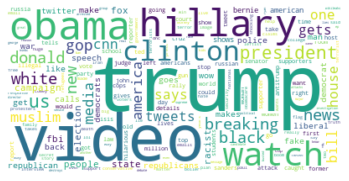

In [61]:
wordcloud_fake = WordCloud(background_color="white").generate_from_frequencies(fake_title_dict)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_fake.to_file("img/faketitles_review.png")

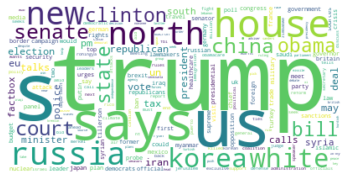

In [62]:
wordcloud_real = WordCloud(background_color="white").generate_from_frequencies(real_title_dict)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_real.to_file("img/realtitles_review.png")